# Features engineering

Transforming the enough raw data in the format depending on the selected model. This is the art of ML, when expertise matters and what most applied ML learning engineers do.

In [1]:
# Add local modules
%load_ext autoreload
%autoreload 2

import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

## Missing data

### Reason

- Completely random (MCAR): unsystematic 
- Random (MAR): reason of missing data has a pattern but is external to the observed variables
- Not at random (MNAR): missing data is related to observed variables

### Imputing

**Dropping** rows is possible if you have enough data but that can bias the dataset. The most common and easiest option is then to replace **Impute** by the **mean or the median for numerical variable**,  the **mode for categorical**, however, that leads to inconsistent data as it doesn't consider its relations with other variables. For text, it's possible to impute using a similar column.

To get more representative features, the best option is to use ML itself:
- KNN: Imputes missing values using k-Nearest Neighbors
- Multiple Imputation by Chained Equations (MICE): Multiple iterations of regression models where each missing value in a variable is inferred depending on the other variables, until all values are predictions based on the relations in the observed data. It assumes missing values are MAR and are initialized through simple imputation before starting to iterate.
- Deep learning or K-Means can be used for categorical data

Below, an example comparing simple imputation and KNN.

In [2]:
import numpy as np

from sklearn.impute import SimpleImputer, KNNImputer

X = [[7, 2, np.nan], [4, np.nan, 6], [10, 5, 9], [4, 2, 8]]
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_knn = KNNImputer(missing_values=np.nan, n_neighbors=2)

imp_mean.fit_transform(X), imp_knn.fit_transform(X)

(array([[ 7.,  2.,  8.],
        [ 4.,  2.,  6.],
        [10.,  5.,  9.],
        [ 4.,  2.,  8.]]),
 array([[ 7. ,  2. ,  8.5],
        [ 4. ,  2. ,  6. ],
        [10. ,  5. ,  9. ],
        [ 4. ,  2. ,  8. ]]))

## Dimensionality reduction

Why? the more data the more computation we need (not linearly!), variables can be correlated and eventually more features will add more noise. Therefore, we need keep what really has more information or classification power.

One of the most use algorithms for dimensionality reduction, it's PCA. It will be discussed in [Unsupervised Learning](3_modelling/3.2.UnsupervisedLearning.ipynb). For now, an example to see how  is used within a ML pipeline.


In [3]:
# PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest

# Load data
X,y = make_classification(n_informative=5, n_redundant=2, n_repeated=2,\
                          n_classes=4, n_clusters_per_class=2)

# Define steps
pca = PCA(n_components=2)
selection = SelectKBest(k=1)
combined_features = FeatureUnion([("pca", pca), ("select", selection)])
classifier = RandomForestClassifier()

# Grid search 
n_components = [1, 3, 5, 10]
select_k=[1, 3, 5, 10]
pipeline = Pipeline([("features", combined_features), ("classifier", classifier)])
param_grid = dict(features__pca__n_components=n_components,
                  features__select__k=select_k)

grid_search = GridSearchCV(pipeline, param_grid=param_grid).fit(X, y)


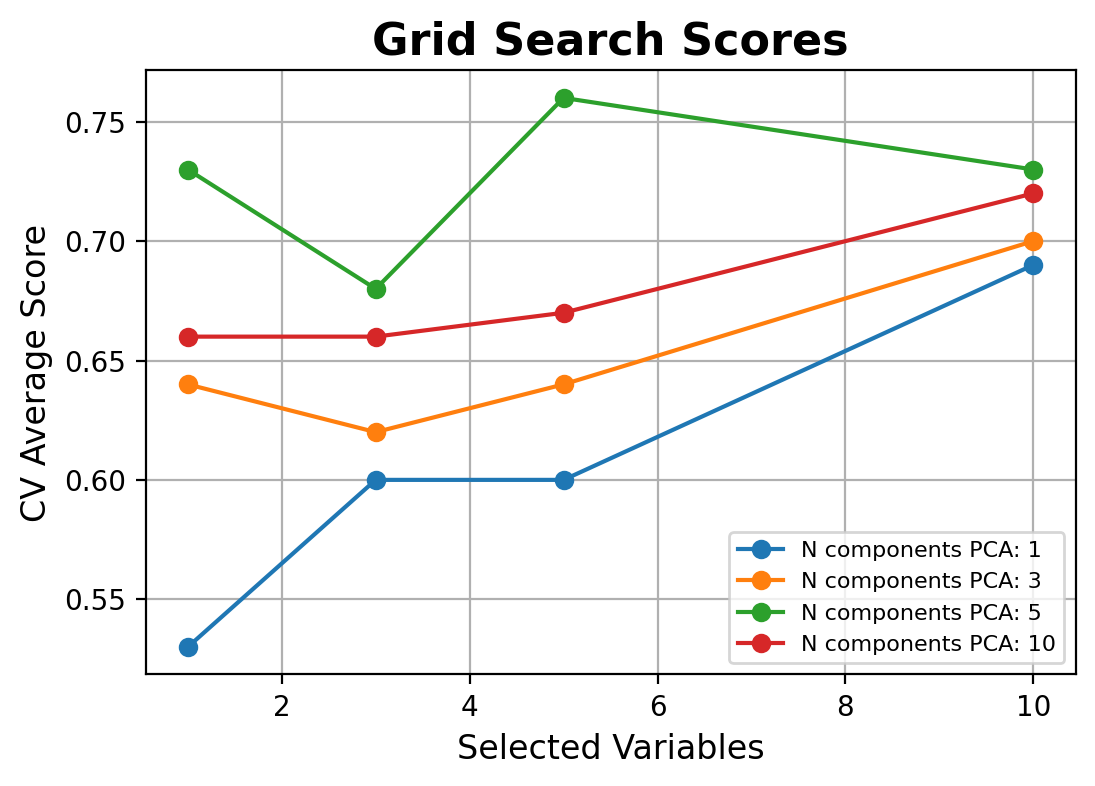

In [4]:
from src.data_analysis import plot_grid_search

plot_grid_search(grid_search.cv_results_, [n_components, select_k], ['N components PCA', 'Selected Variables'])

## Outliers

Detecting outliers can be necessary to understand its cause (they may indicate errors in the data collection process), remove them (as some algorithms are not robust to outliers) or because that is the purpose itself in our use case (fraud detection).

We can find 2 different cases:  
- Outlier detection: Training data has outliers and we want to find/ignore datapoints outside the most concentrated regions.
- Novelty detection: Training data doesn't have a outliers and we want to determine if a new entry belongs to the current distribution (inlier).

### Algorithms
- Local Outlier Factor: Based on K-means, it estimates the relative local density of a data point with respect to its neighbors. 
- Isolation Forest: Based on decision trees, it estimates the average length of random partitions to isolate a data point.

In [5]:
import numpy as np

from sklearn.datasets import make_blobs

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Load data
n_inliers, n_outliers = 100, 20
X = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .5], n_samples=n_inliers, n_features=2)[0]
y = np.ones(n_inliers)
# Add outliers
outliers = np.random.choice([1, -1], 2*n_outliers).reshape(n_outliers, 2) * np.random.uniform(low=3, high=6, size=(n_outliers, 2))
y_outliers = np.full(n_outliers, -1)
X = np.concatenate((X, outliers), axis=0)
y = np.concatenate((y, y_outliers), axis=0)

# Estimating outliers LOF
# Set novelty to true to be able to use the predict function
lof = LocalOutlierFactor(novelty=True)
lof = lof.fit(X)
# Estimating outliers Isolation Forest
isf = IsolationForest()
isf = isf.fit(X)

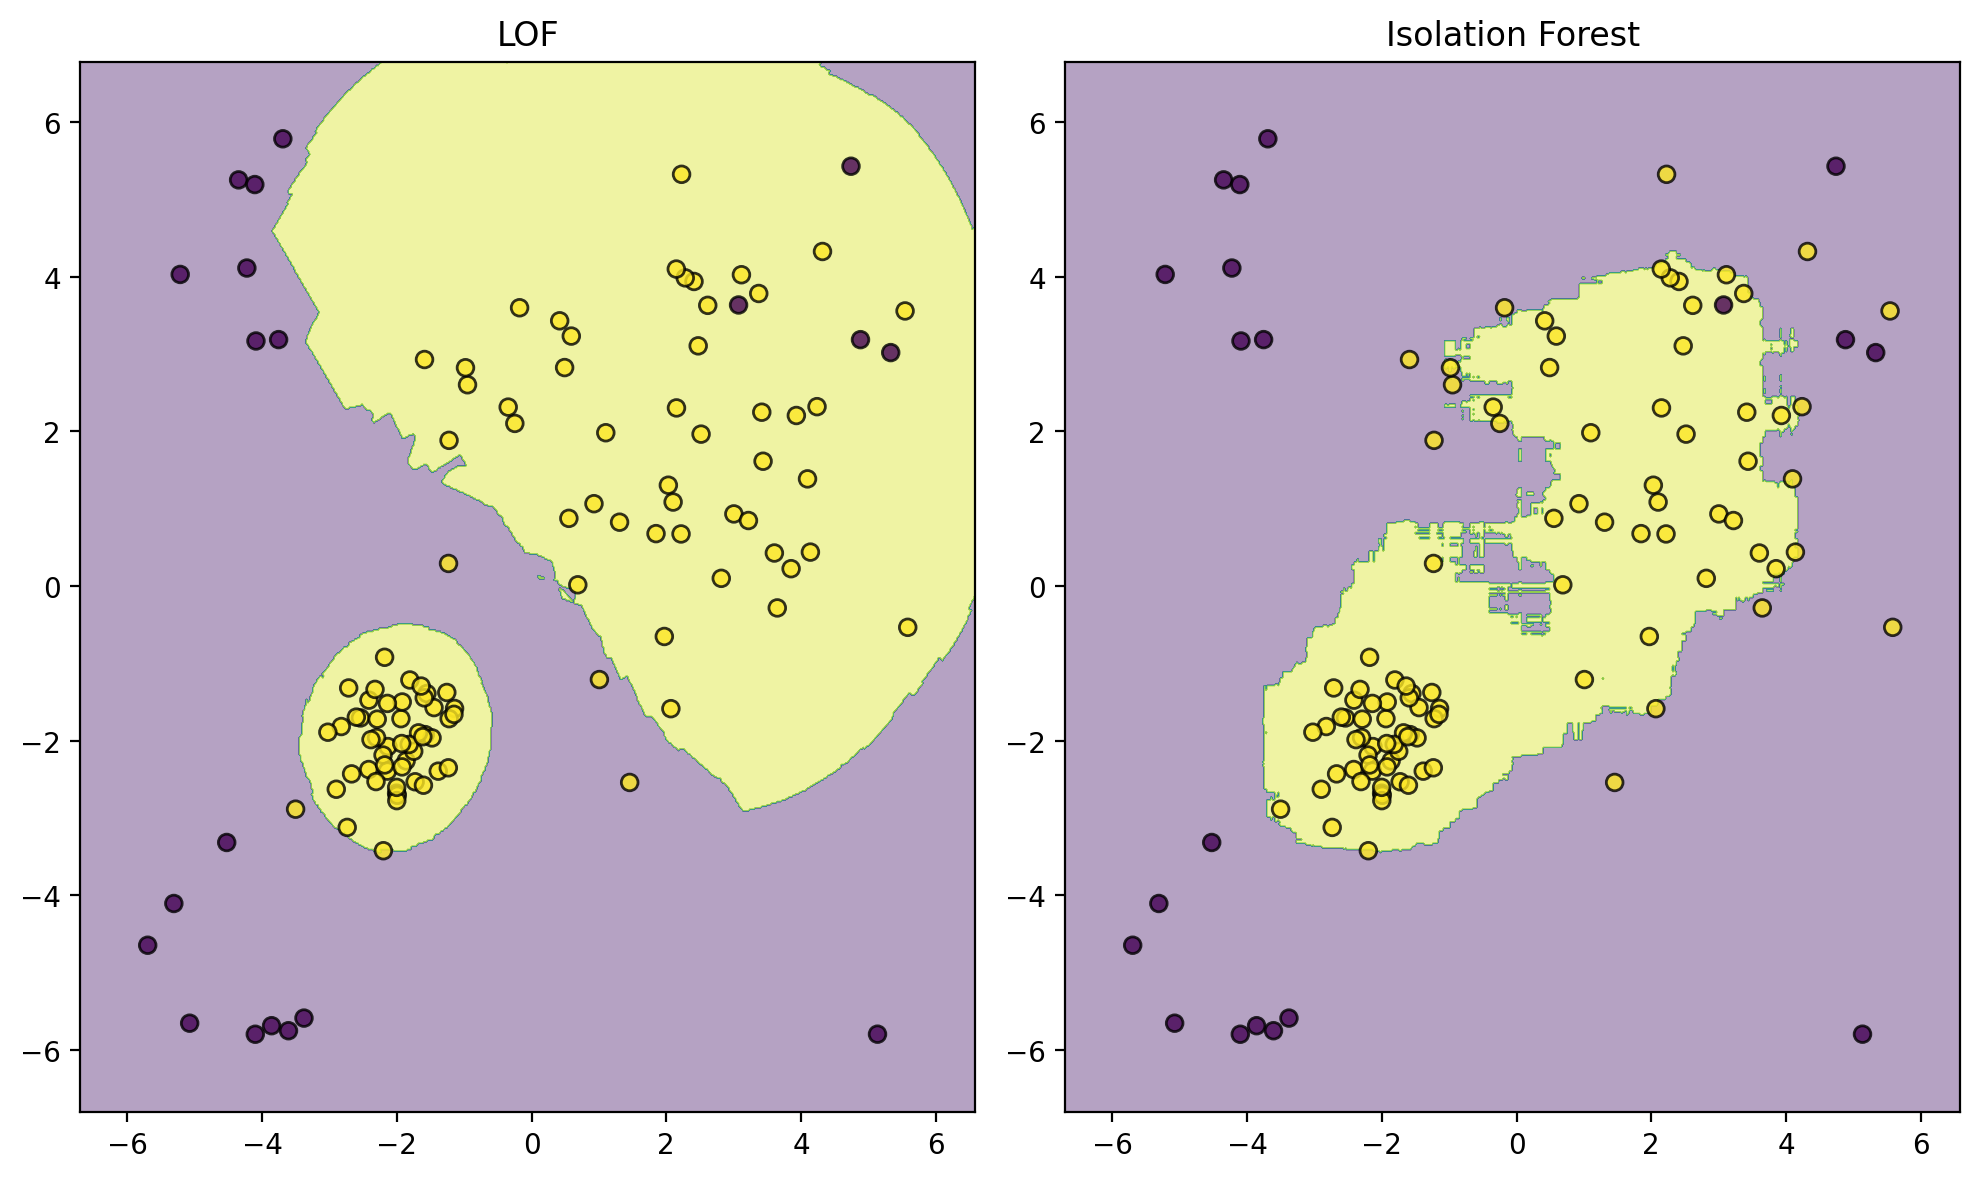

In [6]:
# Plot compairing outlier detection
import matplotlib.pyplot as plt

from src.modelling import plot_decision_function

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax_arr = (ax1, ax2)
od_arr = (lof, isf)
nm_arr = ['LOF', 'Isolation Forest']

for i, (ax, clf) in enumerate(zip(ax_arr, od_arr)):
    plot_decision_function(X, y, clf, ax)
    ax.set_title(nm_arr[i])
fig.tight_layout()

## Unbalanced datasets

Normally a problem for anomaly detection where we have few samples of the class to be detected.

Techniques for balancing:
- Undersampling: drop rows of the classes with more samples in the trainging dataset
- Oversampling: duplicate rows of the minority class in the trainging dataset
- Adjust thresohld: increase the thresohld in which a sample is classified in a class, it may increase false negatives
- Class weight adjustments: Give different weights to each class, so that a missclassification of the underrepresented class increases the cost function at a higher proportion. If there are no missclassifications, it won't have much effect.
- SMOTE (Synthetic Minority Oversampling Technique): creates new rows using KNN
- ADASYN (Adaptive Synthetic): Initialize as SMOTE and then creates new rows focusing on classes that are difficult to learn (which are the minority within a neighborhood)

You can see a comparison between the last two using the **imblearn** library.

In [7]:
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE, ADASYN

# Load data
X, y = make_classification(n_samples=2000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.04, 0.96],
                           class_sep=0.7, random_state=0)

# Resampling SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
clf_smote = LinearSVC().fit(X_resampled, y_resampled)

# Resampling ADASYN
X_resampled, y_resampled = ADASYN().fit_resample(X, y)
clf_adasyn = LinearSVC().fit(X_resampled, y_resampled)

Using TensorFlow backend.


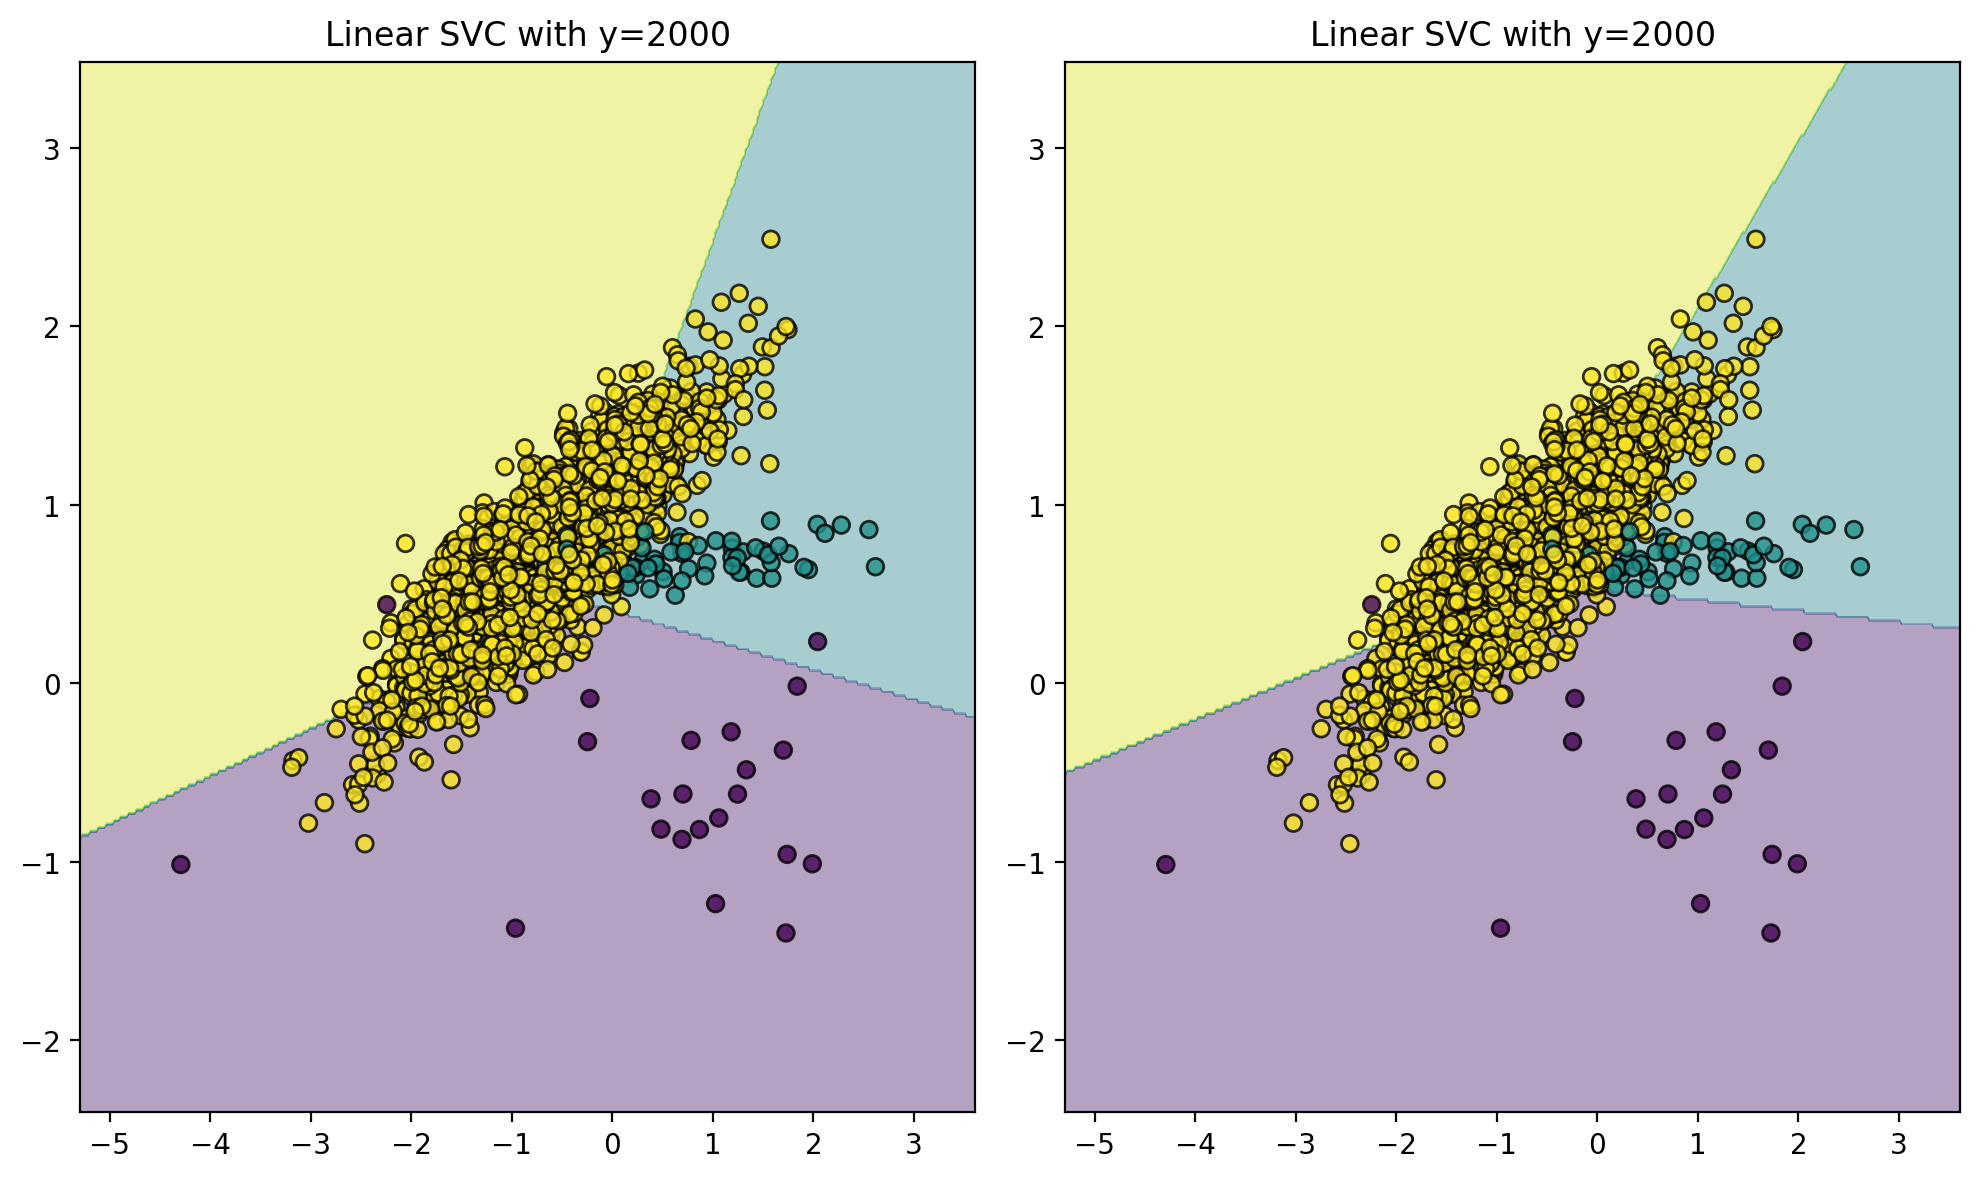

In [8]:
# Plot compairing decision functions
import matplotlib.pyplot as plt

from src.modelling import plot_decision_function

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax_arr = (ax1, ax2)
cls_arr = (clf_smote, clf_adasyn)

for ax, clf in zip(ax_arr, cls_arr):
    plot_decision_function(X, y, clf, ax)
    ax.set_title('Linear SVC with y={}'.format(len(y)))
fig.tight_layout()

## Features for text

Text data required specific features to create language models or word embeddings.

### Word Level
- **Morphological information:** Words can be split into letters and it is possible to extract pre-fixes (i.e. un-, anti-, mono-), suffixes (i.e. -ed, -ing, -ly, -est), lemmas which is a word root of a set of words (i.e. book for booking, booked, books) and stems which is a sequence root of a set of words (i.e. writ for write, writer, writing).

- **Lexical information:** Lexical resources as WordNet which can be extended with additional properties as sentiments for Sentiment Analysis in the SentiWordNet. These datasets have for each word definitions with synonyms, part of speech (nouns, verbs, adjectives, and adverbs), and degrees of positivity, negativity, and neutrality in the case of the SentiWordNet.

## Features for text

- **Bag-of-words:** set of words with their frequency in a document. To have more insight over the document, frequencies must be weighted. Common words or stop words (i.e. the, a, I, will, etc.) do not describe a document as they are always present. For that, the Term Frequency (TF) is multiplied into the Inverse Document Frequency (IDF) to get the TF-IDF. The IDF is the the total number of documents divided by the total number of documents where the word occurs. Then, a word that appears in each document will have a TD-IDF equal to zero.

- **Words in Context:** to predict the next word or determine the part of the speech, a context is required. In that cases, the n-grams (bigrams, trigrams, 4-grams, etc.) are used to create features or language models.
Linguistic properties: linguistics properties include Part-of-Speech tags, Syntactic Parsing, Named-Entity Recognition (NER), Semantic Role Labelling (SRL), etc. 


Here, an example showing text preprocessing to get TF-IDF features.

In [9]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    'I love you only because it is you the one I love,',
    'I hate you deeply, and hating you,',
    'Bend to you, and the measure of my changing love for you,',
    'Is that I do not see you but love you blindly.',
]

# Remove stop words
vectorizer = TfidfVectorizer(corpus, stop_words='english')
# Learn vocabulary and idf
X = vectorizer.fit_transform(corpus)

In [10]:
# Stop words applied
len(vectorizer.get_stop_words() or []) 

318

In [11]:
# document-term matrix
pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())


bend   blindly  changing   deeply     hate   hating      love   measure
0  0.000000  0.000000  0.000000  0.00000  0.00000  0.00000  1.000000  0.000000
1  0.000000  0.000000  0.000000  0.57735  0.57735  0.57735  0.000000  0.000000
2  0.541736  0.000000  0.541736  0.00000  0.00000  0.00000  0.345783  0.541736
3  0.000000  0.842926  0.000000  0.00000  0.00000  0.00000  0.538029  0.000000